Using device: cpu
Epoch 0, Loss: 1.216961e+00
Epoch 500, Loss: 2.444098e-04
Epoch 1000, Loss: 5.029851e-05
Epoch 1500, Loss: 4.248089e-05
Epoch 2000, Loss: 3.561299e-05
Epoch 2500, Loss: 2.956747e-05
Epoch 3000, Loss: 2.423421e-05
Epoch 3500, Loss: 1.944715e-05
Epoch 4000, Loss: 1.509242e-05
Epoch 4500, Loss: 1.113579e-05


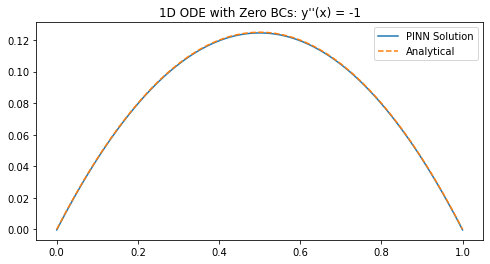

In [3]:
"""
Title: 1D ODE with Zero Boundary Conditions using PINNs

We solve the boundary value problem:
    y''(x) = -1,  x in (0,1),
with boundary conditions:
    y(0) = 0
    y(1) = 0

Analytical solution:
    y(x) = -x^2/2 + x/2

PINN approach:
    - A small neural network y_theta(x) approximates y(x).
    - We compute y'(x) and y''(x) via automatic differentiation.
    - Residual: y''(x) + 1 = 0
    - Loss = MSE(residual) + MSE(BC at x=0) + MSE(BC at x=1)
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if available for performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ODE_Net(nn.Module):
    """
    Simple fully-connected network for y(x).
    We'll use 3 layers: input -> hidden -> hidden -> output,
    each hidden with Tanh activation.
    """
    def __init__(self, hidden_units=20):
        super(ODE_Net, self).__init__()
        self.layer1 = nn.Linear(1, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        """
        Forward pass for input x of shape (N,1).
        """
        out = self.activation(self.layer1(x))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

def residual(model, x):
    """
    Compute the ODE residual for y''(x) + 1 = 0.

    Args:
        model: The ODE_Net instance
        x: A tensor of shape (N,1) in the interior domain (0,1)

    Returns:
        A tensor of shape (N,1) with the PDE residual.
    """
    # Enable gradient for x
    x.requires_grad_(True)

    # Predict y(x)
    y = model(x)

    # First derivative
    dydx = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    # Second derivative
    d2ydx2 = torch.autograd.grad(
        dydx, x,
        grad_outputs=torch.ones_like(dydx),
        create_graph=True
    )[0]

    # PDE residual: y''(x) + 1 = 0 -> y''(x) + 1
    res = d2ydx2 + 1.0
    return res

def main():
    # Instantiate the network
    model = ODE_Net().to(device)

    # Setup the optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 5000

    # Generate some sample points in (0,1) for the interior
    N_interior = 50
    x_interior = torch.rand(N_interior, 1, device=device)  # uniform in [0,1]

    # Boundary points
    x_bc0 = torch.tensor([[0.0]], device=device)  # for x=0
    x_bc1 = torch.tensor([[1.0]], device=device)  # for x=1

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1) PDE residual on the interior
        r_interior = residual(model, x_interior)
        loss_res = torch.mean(r_interior**2)

        # 2) Boundary losses: y(0)=0, y(1)=0
        y_bc0 = model(x_bc0)
        y_bc1 = model(x_bc1)
        loss_bc0 = torch.mean(y_bc0**2)  # want y(0)=0
        loss_bc1 = torch.mean(y_bc1**2)  # want y(1)=0

        # 3) Total loss
        loss = loss_res + loss_bc0 + loss_bc1
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

    # --- Evaluate / visualize ---
    model.eval()
    x_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
    y_pred = model(x_test).detach().cpu().numpy().flatten()
    x_test_np = x_test.cpu().numpy().flatten()

    # Analytical solution: y(x) = -x^2/2 + x/2
    y_true = -0.5 * x_test_np**2 + 0.5 * x_test_np

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(x_test_np, y_pred, label="PINN Solution")
    plt.plot(x_test_np, y_true, '--', label="Analytical")
    plt.legend()
    plt.title("1D ODE with Zero BCs: y''(x) = -1")
    plt.show()

if __name__ == "__main__":
    main()
